### READ ME
This is a final project for the course 'Business Data Analytics, Quantitative Methods and Visualization' (2021, Copenhagen Business School).
The goal of this project is to be able to predict the outcome of a certain UFC fight, more specifically to predict whether the Red or Blue fighter is more likely to win the match.

We are going to do this through the following steps:
1. __Importing necessary libraries and tools.__
2. __Loading, Cleaning & Exploring the dataset.__
3. __Data pre-processing.__
4. __Machine Learning Models.__
5. __Making a prediction.__
6. __Showcasing results.__

### Legend

- ufc = the original dataset
- column_names = list of column names
- ufc_df = the dataset without NaNs
- datatypes = dictionary with column names + their datatypes
- ufc_ohe = one hot encoded dataset

# 1. Importing necessary libraries and tools.

In [81]:
# libraries

import pandas as pd #used
import matplotlib.pyplot as plt #used
import numpy as np #used
import seaborn as sns #used

# models

from sklearn.neighbors import KNeighborsClassifier #used
from sklearn.neural_network import MLPClassifier #used
from sklearn.tree import DecisionTreeClassifier #used
from sklearn.ensemble import RandomForestClassifier #used
from sklearn.preprocessing import StandardScaler 



from sklearn.preprocessing import MinMaxScaler #used
from sklearn.feature_selection import SelectKBest #used
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# use cross validation with grid search as well. 
from sklearn.model_selection import GridSearchCV

# other tools

from sklearn.model_selection import train_test_split #used
from sklearn.metrics import accuracy_score #used

import warnings #used

# 2. Loading, Cleaning & Exploring the dataset.

### 2.1 Load excel file (ufc.xlsx) and print out the first couple rows.

In [82]:
ufc = pd.read_excel('newestdataset.xlsx')

### 2.2 Get number of rows and columns.

In [83]:
# print('Number of rows:', ufc.shape[0])
# print('Number of columns:', ufc.shape[1])

### 2.3 Get the list of column names.

In [84]:
column_names = ufc.columns

#### *We can call this list whenever we want to check the name of a column.*

### 2.4 Check for missing data.

In [85]:
# ufc.info()

#### As we can see, there are some NaNs in these columns that should later be taken care of:
- B_avg_SIG_STR_landed
- B_avg_SIG_STR_pct
- B_avg_SUB_ATT     
- B_avg_TD_landed      
- B_avg_TD_pct
- R_avg_SIG_STR_landed
- R_avg_SIG_STR_pct
- R_avg_SUB_ATT     
- R_avg_TD_landed      
- R_avg_TD_pct  

### 2.5 Check for duplicates.

In [86]:
duplicates = ufc.duplicated()
ufc[duplicates]

,Unnamed: 0,R_odds_dec,B_odds_dec,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,...,R_Height_cms,R_Reach_ins,R_Reach_cms,R_Weight_lbs,R_UFC_fights,R_age,Reach_diff_ins,Age_diff,R_odds,B_odds


#### *It seems that there are no duplicates, therefore, we only need to focus on NaN values.*

### 2.6 Delete rows with at least 1 missing value (NaN).

In [87]:
ufc_df = ufc.dropna()

print('Number of rows:', ufc_df.shape[0])
print('Number of columns:', ufc_df.shape[1])

Number of rows: 2697
Number of columns: 78


#### *xxx rows got dropped.*

### 2.7 Check if columns have the right datatype.

In [88]:
# datatypes = ufc_df.dtypes.to_dict()
# datatypes

- O = object
- int64 = integer
- float64 = float
- <M8[ns] = date ("On a machine whose byte order is little endian, there is no difference between *np.dtype('datetime64[ns]')* and *np.dtype('<M8[ns]')*")
- bool = True/False

### 2.8 Fix datatypes if necessary.

### 2.9 Use info() again to check missing values and datatypes.

### 2.10 Create a dataframes for visualizations.

In [89]:
# General features
ufc_gen = ufc_df[['R_odds_dec', 'B_odds_dec', 'date', 'location', 'Winner', 'weight_class', 'Reach_diff_ins', 'Age_diff']]

### 2.11 Use head() for a better overview.

In [90]:
ufc_gen.head()

,R_odds_dec,B_odds_dec,date,location,Winner,weight_class,Reach_diff_ins,Age_diff
0,2.450000,1.606061,2019-06-08,"Chicago, Illinois, USA",Red,Bantamweight,3.0,1
1,1.090909,8.000000,2019-06-08,"Chicago, Illinois, USA",Red,Women's Flyweight,0.0,1
2,1.476190,2.750000,2019-06-08,"Chicago, Illinois, USA",Red,Lightweight,3.0,1
3,4.000000,1.277778,2019-06-08,"Chicago, Illinois, USA",Blue,Bantamweight,1.0,3
4,1.625000,2.400000,2019-06-08,"Chicago, Illinois, USA",Blue,Heavyweight,2.0,6


### 2.12 General features.

#### 2.12.1 Odds.

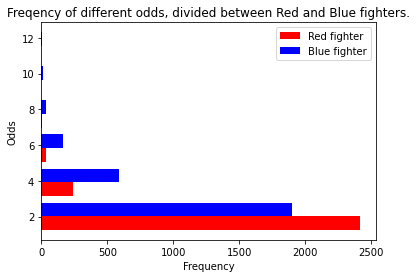

In [91]:
plt.hist(ufc_gen[['R_odds_dec', 'B_odds_dec']], color = ['Red', 'Blue'], bins = 6, orientation = 'horizontal', label = ['Red fighter', 'Blue fighter'])
plt.xlabel('Frequency')
plt.ylabel('Odds')
plt.title('Freqency of different odds, divided between Red and Blue fighters.')
plt.legend()
plt.show()

*The graph basically shows that there were approximately 2400 fights where the Red Fighter's odds were around 1-2, while there were only around 1900 where Blue Fighters had such a low odds (which means higher chance to win). However, in case of higher odds (which means less chance of winning the fight) Blue Fighters are dominating.* 

*From these, we can see that Red Fighters have lower odds in general which proves that statistically, they have higher chances to win. This seems logical as Red fighters are usually Favorites and Blue Fighters are underdogs.*

#### 2.12.2 Location.

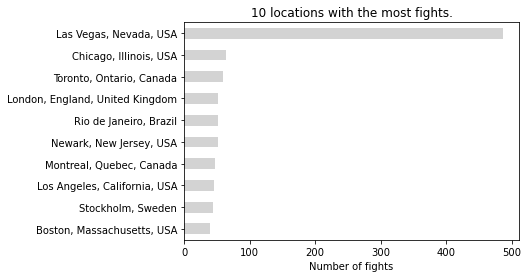

In [92]:
ufc_gen['location'].value_counts().head(10).sort_values(ascending = True).plot(kind = 'barh', color = 'Lightgrey')
plt.xlabel('Number of fights')
plt.title('10 locations with the most fights.')
plt.show()

*Seems skewed, it's worth considering leaving location out.*

#### 2.12.3 Winner.

D:\Programmes\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


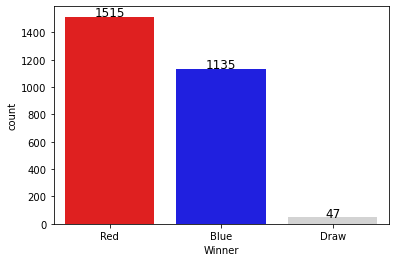

In [93]:
ax = sns.countplot(ufc_gen['Winner'], palette = ['Red', 'Blue', 'Lightgrey'])

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(), ha = 'center', va = 'baseline', color = 'black', size = 12
            )

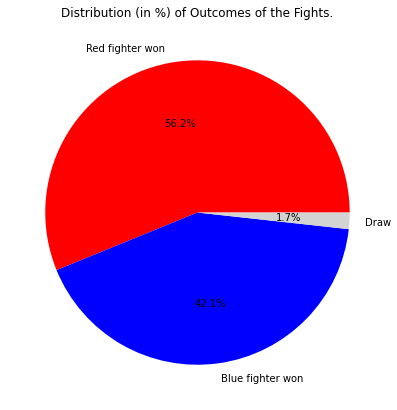

In [94]:
ufc_gen['Winner'].value_counts().plot.pie(colors = ['Red', 'Blue', 'Lightgrey'], 
                labels=['Red fighter won', 'Blue fighter won', 'Draw'], autopct='%.1f%%', figsize = (7,7))
plt.ylabel('')
plt.title('Distribution (in %) of Outcomes of the Fights.')
plt.show()

*Based on the 2 graphs above, we can say that Red Fighters win more often which is probably because the Red Fighter is the Favorite.*

*If 56.2% of UFC fights end with a Red-win, one could say that he should always bet on the Red Fighter for higher chances.*

*Our goal is to exceed that 56.2% with our machine learning algorithm, and to be able to make more exact and appropiate decisions.* 

#### 2.12.4 Weight class.

<AxesSubplot:xlabel='weight_class'>

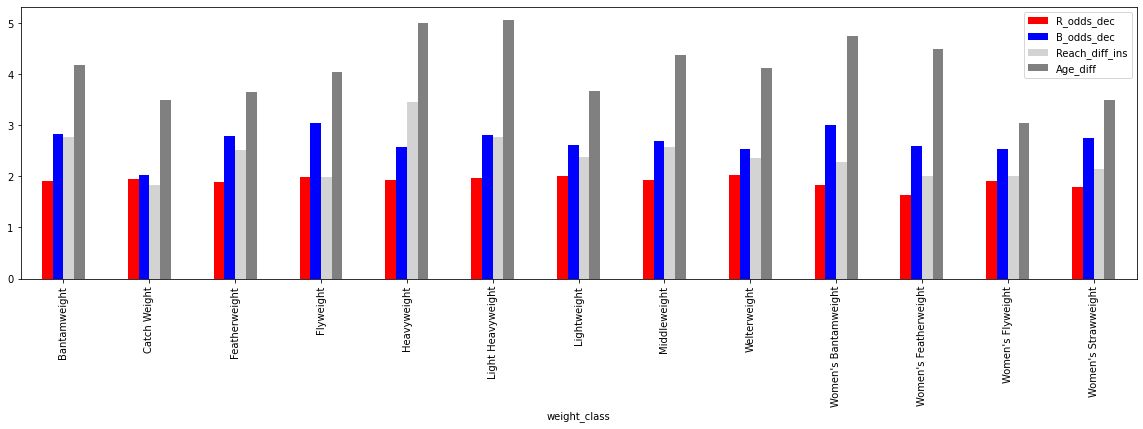

In [95]:
# would be nice to divide it to two graphs by gender

ufc_gen.groupby('weight_class').mean().plot.bar(figsize=(20,5), color = ['Red', 'Blue', 'Lightgrey', 'Grey', 'Black'])

#### *We can see that the features included in this visualization highly depend on what weight class we are talking about, therefore, we should definetely include 'weight_class' in our most important features.*

#### 2.12.5 Reach & Age Difference.

In [ ]:
plt.figure(figsize=(20,6))
ufc_gen.Age_diff.hist(bins = 40, color = 'grey')
plt.xlabel('Age difference')
plt.ylabel('Number of Fights')
plt.title('Number of Fights with various Age differences')
plt.show()

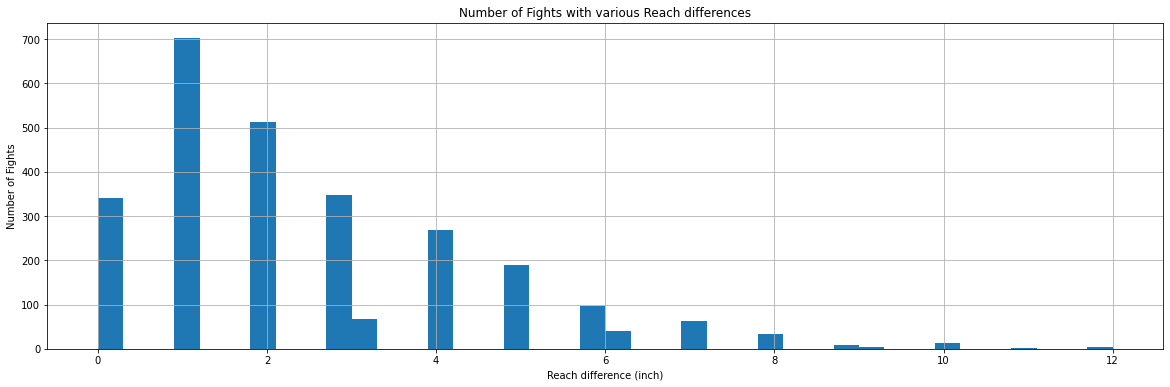

In [97]:
plt.figure(figsize=(20,6))
ufc_gen.Reach_diff_ins.hist(bins = 40)
plt.xlabel('Reach difference (inch)')
plt.ylabel('Number of Fights')
plt.title('Number of Fights with various Reach differences')
plt.show()

### 2.13 Fighter Features.

<AxesSubplot:>

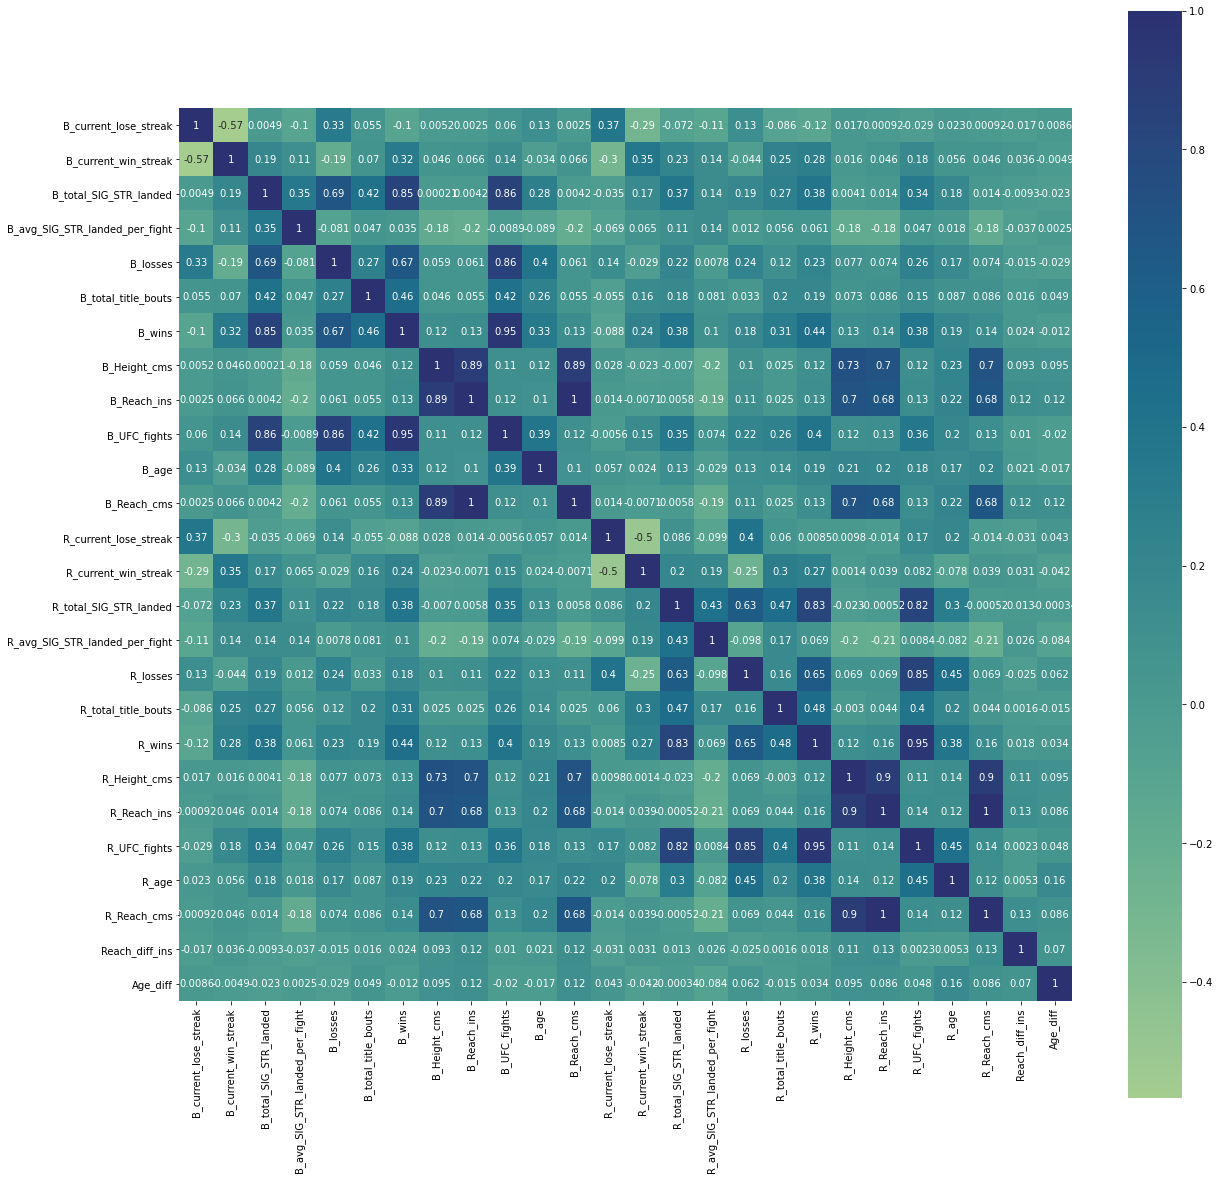

In [98]:
corr_features = ['B_current_lose_streak', 'B_current_win_streak', 'B_total_SIG_STR_landed',
                'B_avg_SIG_STR_landed_per_fight', 'B_losses', 'B_total_title_bouts',
                 'B_wins', 'B_Height_cms', 'B_Reach_ins', 'B_UFC_fights', 'B_age', 'B_Reach_cms', 'R_current_lose_streak',
                 'R_current_win_streak', 'R_total_SIG_STR_landed', 'R_avg_SIG_STR_landed_per_fight', 'R_losses',
                 'R_total_title_bouts', 'R_wins', 'R_Height_cms', 'R_Reach_ins', 'R_UFC_fights', 'R_age', 'R_Reach_cms',
                 'Reach_diff_ins', 'Age_diff']
corr = ufc_df[corr_features].corr(method='pearson')

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(corr, square= True, annot = True, cmap = cmap)

- height & reach are highly correlated, we could keep only one of them (as we included reach difference, i think we should keep reach difference)

# 3. Data Pre-processing.

### 4.1 Drop unnecessary columns.

In [99]:
ufc_df = ufc_df.drop(labels = ['R_fighter', 'B_fighter', 'location',
       'Referee', 'date', 'R_odds', 'B_odds', 'R_Weight_lbs', 'B_Weight_lbs', 'no_of_rounds'], axis = 1)

### 4.2 Deal with nominal features.

In [100]:
# one hot encoding
onehot_columns = ['weight_class', 'R_Stance', 'B_Stance']

ufc_ohe = pd.get_dummies(ufc_df, columns = onehot_columns, drop_first=True)
ufc_ohe.head()

,Unnamed: 0,R_odds_dec,B_odds_dec,Winner,title_bout,B_current_lose_streak,B_current_win_streak,B_avg_KD,B_SLpM,B_SApM,...,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch
0,0,2.450000,1.606061,Red,True,0,4,0.800000,3.233190,2.603720,...,0,0,0,0,1,0,0,1,0,0
1,1,1.090909,8.000000,Red,True,0,3,0.000000,3.625442,3.427562,...,0,0,1,0,0,1,0,1,0,0
2,2,1.476190,2.750000,Red,False,0,3,0.645161,4.823151,4.623572,...,0,0,0,0,1,0,0,1,0,0
3,3,4.000000,1.277778,Blue,False,0,4,0.500000,6.464724,2.921779,...,0,0,0,0,1,0,0,0,0,1
4,4,1.625000,2.400000,Blue,False,0,1,0.000000,3.075000,4.500000,...,0,0,0,0,0,1,0,0,1,0


In [101]:
ufc_ohe.columns

Index(['Unnamed: 0', 'R_odds_dec', 'B_odds_dec', 'Winner', 'title_bout',
       'B_current_lose_streak', 'B_current_win_streak', 'B_avg_KD', 'B_SLpM',
       'B_SApM', 'B_Sd', 'B_total_SIG_STR_landed',
       'B_avg_SIG_STR_landed_per_fight', 'B_losses',
       'B_avg_SIG_STR_absorberd_per_fight', 'B_total_SIG_STR_absorbed',
       'B_avg_opp_TOTAL_STR_landed', 'B_total_rounds_fought',
       'B_total_time_fought(minutes)', 'B_total_time_fought(seconds)',
       'B_avg_time_fought_per_fight(seconds)', 'B_total_title_bouts',
       'B_win_by_Decision_Majority', 'B_win_by_Decision_Split',
       'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission',
       'B_win_by_TKO_Doctor_Stoppage', 'B_wins', 'B_Height_cms', 'B_Reach_ins',
       'B_UFC_fights', 'B_age', 'B_Reach_cms', 'R_current_lose_streak',
       'R_current_win_streak', 'R_avg_KD', 'R_SLpM', 'R_SApM', 'R_Sd',
       'R_total_SIG_STR_absorbed', 'R_total_SIG_STR_landed',
       'R_avg_SIG_STR_landed_per_fight', '

In [102]:
X = ufc_ohe[['B_current_lose_streak', 'B_current_win_streak', 'B_total_SIG_STR_landed',
                'B_avg_SIG_STR_landed_per_fight', 'B_losses', 'B_total_title_bouts',
                 'B_wins', 'B_Height_cms', 'B_Reach_ins', 'B_UFC_fights', 'B_age', 'B_Reach_cms', 'R_current_lose_streak',
                 'R_current_win_streak', 'R_total_SIG_STR_landed', 'R_avg_SIG_STR_landed_per_fight', 'R_losses',
                 'R_total_title_bouts', 'R_wins', 'R_Height_cms', 'R_Reach_ins', 'R_UFC_fights', 'R_age', 'R_Reach_cms',
                 'Reach_diff_ins', 'Age_diff', 'weight_class_Catch Weight', 'weight_class_Featherweight',
       'weight_class_Flyweight', 'weight_class_Heavyweight',
       'weight_class_Light Heavyweight', 'weight_class_Lightweight',
       'weight_class_Middleweight', 'weight_class_Welterweight',
       'weight_class_Women\'s Bantamweight',
       'weight_class_Women\'s Featherweight', 'weight_class_Women\'s Flyweight',
       'weight_class_Women\'s Strawweight', 'R_Stance_Orthodox',
       'R_Stance_Southpaw', 'R_Stance_Switch', 'B_Stance_Orthodox',
       'B_Stance_Southpaw', 'B_Stance_Switch']]
y = ufc_ohe['Winner']

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (2697, 44)
y shape: (2697,)


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### 4.5 Deal with numerical features.

In [104]:
scale_columns = ['B_current_lose_streak', 'B_current_win_streak', 'B_total_SIG_STR_landed',
                'B_avg_SIG_STR_landed_per_fight', 'B_losses', 'B_total_title_bouts',
                 'B_wins', 'B_Height_cms', 'B_Reach_ins', 'B_UFC_fights', 'B_age', 'B_Reach_cms', 'R_current_lose_streak',
                 'R_current_win_streak', 'R_total_SIG_STR_landed', 'R_avg_SIG_STR_landed_per_fight', 'R_losses',
                 'R_total_title_bouts', 'R_wins', 'R_Height_cms', 'R_Reach_ins', 'R_UFC_fights', 'R_age', 'R_Reach_cms',
                 'Reach_diff_ins', 'Age_diff']

scaler = StandardScaler()

X_train[scale_columns] = scaler.fit_transform(X_train[scale_columns])

X_test[scale_columns] = scaler.transform(X_test[scale_columns])

warnings.filterwarnings("ignore")

<ipython-input-104-8ecba3d2d6b1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[scale_columns] = scaler.fit_transform(X_train[scale_columns])
D:\Programmes\conda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-104-8ecba3d2d6b1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

### 4.7 Select the 20 most influential features.

In [105]:
# selecting best features
print(X.shape)

k_best = SelectKBest(k = 20)
k_best.fit(X_train, y_train)
X_train_k_best = k_best.transform(X_train)
X_test_k_best = k_best.transform(X_test)

print(X_train_k_best.shape)
print(X.columns[k_best.get_support()])

best_features = X.columns[k_best.get_support()]

warnings.filterwarnings("ignore")

(2697, 44)
(2022, 20)
Index(['B_current_win_streak', 'B_avg_SIG_STR_landed_per_fight', 'B_losses',
       'B_total_title_bouts', 'B_Height_cms', 'B_Reach_ins', 'B_age',
       'B_Reach_cms', 'R_current_lose_streak', 'R_current_win_streak',
       'R_total_SIG_STR_landed', 'R_avg_SIG_STR_landed_per_fight', 'R_losses',
       'R_UFC_fights', 'R_age', 'Age_diff', 'weight_class_Flyweight',
       'weight_class_Welterweight', 'R_Stance_Orthodox', 'R_Stance_Southpaw'],
      dtype='object')


### 4.8 Set X but only with the best features.

In [106]:
X = ufc_ohe[best_features]
y = ufc_ohe['Winner']

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (2697, 20)
y shape: (2697,)


In [107]:
# Define the new X & y in train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 5. Machine Learning Models.

### 5.1 Build models.

In [108]:
# knn
knn = KNeighborsClassifier()

# neural network
mpl = MLPClassifier()

# decision tree
tree = DecisionTreeClassifier()

# random forest
forest = RandomForestClassifier()

classifiers = (knn, mpl, tree, forest)

### 5.2 Build the 'applyModel' function.

In [109]:
def applyModel(model,name,X_train, y_train, X_test, y_test):
    m = model.fit(X_train,y_train)
    print(name, '- Training accuracy:', m.score(X_train, y_train))
    print(name, '- Testing accuracy:', m.score(X_test, y_test))

### 5.3 Train and test with the different models.

In [110]:
for c in classifiers:
    n = str(c)
    applyModel(c, n, X_train, y_train, X_test, y_test)
    print('')
    
warnings.filterwarnings("ignore")

KNeighborsClassifier() - Training accuracy: 0.6988130563798219
KNeighborsClassifier() - Testing accuracy: 0.5096296296296297

MLPClassifier() - Training accuracy: 0.5840751730959446
MLPClassifier() - Testing accuracy: 0.5792592592592593

DecisionTreeClassifier() - Training accuracy: 1.0
DecisionTreeClassifier() - Testing accuracy: 0.5362962962962963

RandomForestClassifier() - Training accuracy: 1.0
RandomForestClassifier() - Testing accuracy: 0.5525925925925926



### Prinipal component analysis (PCA)

In [111]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [112]:
principalDf

,principal component 1,principal component 2
0,175.733678,-4.733439
1,152.430709,26.878893
2,568.152163,6.130712
3,102.201197,39.495100
4,-134.199105,25.491318
...,...,...
2692,97.525319,-15.033987
2693,-56.970312,-32.964357
2694,66.353805,-21.493491
2695,-183.677365,-12.007602


In [113]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [114]:
finalDf

,principal component 1,principal component 2,Winner
0,175.733678,-4.733439,Red
1,152.430709,26.878893,Red
2,568.152163,6.130712,Red
3,102.201197,39.495100,Blue
4,-134.199105,25.491318,Blue
...,...,...,...
3847,NaN,NaN,Red
3848,NaN,NaN,Red
3849,NaN,NaN,Red
3850,NaN,NaN,Blue


In [115]:
# explained of the variance. We can see that the first explains most of the variance 
pca.explained_variance_ratio_

array([0.98509333, 0.00662526])

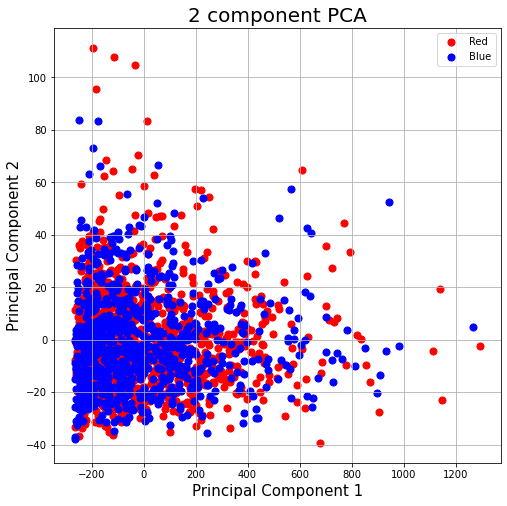

In [116]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Red', 'Blue']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Winner'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#### Heatmap of components 

In [117]:
pca.components_

array([[ 1.40252469e-03,  9.06737124e-03,  1.89990821e-03,
         8.64368240e-04, -2.71823794e-04,  9.00873036e-05,
         2.12025182e-03,  2.28821750e-04,  3.22632513e-04,
         1.57058126e-03,  9.99233522e-01,  3.09824797e-02,
         6.18665937e-03,  2.02669425e-02,  5.26100726e-03,
        -6.34454989e-06, -1.79611813e-05,  9.26879442e-05,
         9.30036476e-06,  5.25799180e-05],
       [ 5.67677565e-03,  8.94898093e-01, -1.43659129e-02,
         6.55768419e-04, -1.84907470e-01, -9.19755311e-02,
        -2.97575799e-02, -2.33617847e-01, -5.24749538e-03,
         6.55177725e-03, -1.63279289e-02,  3.10525217e-01,
        -2.23776138e-02, -5.16710590e-02, -2.83667093e-02,
        -7.75859990e-03,  1.24336456e-03, -1.49606953e-03,
         1.24144638e-03, -1.20991103e-03]])

<AxesSubplot:>

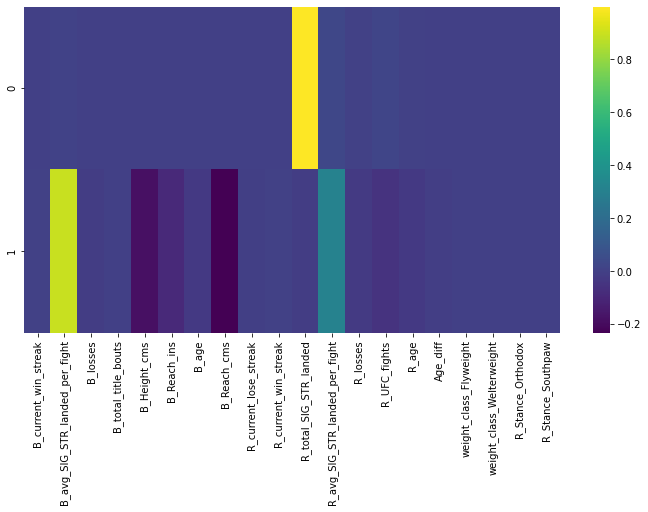

In [118]:
map = pd.DataFrame(pca.components_,columns=["B_current_win_streak", "B_avg_SIG_STR_landed_per_fight", "B_losses", "B_total_title_bouts", "B_Height_cms", "B_Reach_ins", "B_age", "B_Reach_cms", "R_current_lose_streak", "R_current_win_streak", "R_total_SIG_STR_landed", "R_avg_SIG_STR_landed_per_fight", "R_losses", "R_UFC_fights", "R_age", "Age_diff", "weight_class_Flyweight", "weight_class_Welterweight", "R_Stance_Orthodox", "R_Stance_Southpaw"])
plt.figure(figsize=(12,6))
sns.heatmap(map,cmap='viridis')

### 5.4 Play around with KNN.

In [119]:
training_accuracy = []
testing_accuracy = []
number_of_neighbors =[]
weighting_choice = []

weight_values = ['distance', 'uniform']

for n_neighbors in range(1,100):
    for weights in weight_values:
        clf = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
        clf.fit(X_train, y_train)
        training_accuracy.append(clf.score(X_train, y_train))
        testing_accuracy.append(clf.score(X_test, y_test))
        number_of_neighbors.append(n_neighbors)
        weighting_choice.append(weights)
      
     
combinations_sorted_knn = sorted(list(zip(number_of_neighbors, weighting_choice, training_accuracy, testing_accuracy)), key = lambda e:e[3], reverse = True)

print('Top 5 results, sorted by test accuracy:\n')
print(*combinations_sorted_knn[0:5], sep = "\n")

# save the best variables
knn_best_n_neighbors = combinations_sorted_knn[0][0]
knn_best_weights = combinations_sorted_knn[0][1]

Top 5 results, sorted by test accuracy:

(9, 'distance', 1.0, 0.5674074074074074)
(79, 'distance', 1.0, 0.5674074074074074)
(78, 'distance', 1.0, 0.5659259259259259)
(80, 'distance', 1.0, 0.5659259259259259)
(83, 'distance', 1.0, 0.5659259259259259)


#### 5.4.1 KNN - Cross validation

In [120]:
#We define the parameters which want to test for the KNN model
param_grid = {
    "n_neighbors": [32,54,74,100], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhatten"], "leaf_size": [10,30,60]
}

#We make the model with cross validation and grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)

#We fit the model, with the best parameters: 
gs_result = grid_search.fit(X_train, y_train)

#print the results: 

print(
    "\n Training score: ", gs_result.best_score_, 
    "\n Best estimator: ", gs_result.best_estimator_
    # ,"\n best parameters: ", gs_result.best_params_
)

print("Test score: ", grid_search.score(X_test,y_test))



 Training score:  0.5469711749500072 
 Best estimator:  KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=74,
                     weights='distance')
Test score:  0.56


### 5.5 Play around with Neural Network.

In [121]:
train_acc = []
test_acc = []
alpha_value = []
learning_rate_value = []


alphas = (0.0001, 0.001, 0.1, 0, 1, 5, 100)
learning_rates = ('constant', 'invscaling', 'adaptive')

for a in alphas:
    for l in learning_rates:
        mpl = MLPClassifier(alpha=a, learning_rate = l)
        mpl.fit(X_train, y_train)
        train_acc.append(accuracy_score(mpl.predict(X_train), y_train))
        test_acc.append(accuracy_score(mpl.predict(X_test), y_test))
        alpha_value.append(a)
        learning_rate_value.append(l)
        

combinations_sorted_mpl = sorted(list(zip(alpha_value, learning_rate_value, train_acc, test_acc)), key = lambda e:e[3], reverse = True)

print('Top 5 results, sorted by test accuracy:\n')
print(*combinations_sorted_mpl[0:5], sep = "\n")

# save the best variables
mpl_best_alpha = combinations_sorted_knn[0][0]
mpl_best_learning_rate = combinations_sorted_knn[0][1]

Top 5 results, sorted by test accuracy:

(0.1, 'constant', 0.5979228486646885, 0.5851851851851851)
(0.001, 'adaptive', 0.586053412462908, 0.5807407407407408)
(100, 'invscaling', 0.6023738872403561, 0.5792592592592593)
(0.001, 'constant', 0.5964391691394659, 0.5762962962962963)
(0, 'invscaling', 0.5969337289812068, 0.5762962962962963)


#### Neural Network - Cross validation

In [ ]:
#We define the parameters which want to test for the decision tree model
param_grid = {"learning_rate":["constant", "invscaling", "adaptive"], "alpha":[0.01,0.01,1,5,10,15]}

#We make the model with cross validation and grid search
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=10)

#We fit the model, with the best parameters: 
gs_result = grid_search.fit(X_train, y_train)

#print the results: 

print(
    "\n Training score: ", gs_result.best_score_, 
    "\n Best estimator: ", gs_result.best_estimator_,
    "\n best parameters: ", gs_result.best_params_,
    "Test score: ", grid_search.score(X_test,y_test)
)

### 5.6 Play around with Decision Tree.

In [ ]:
train_acc = []
test_acc = []
max_depth_value = []

for i in range(1,30):
    dt = DecisionTreeClassifier(max_depth = i, random_state=0)
    dt.fit(X_train, y_train)
    train_acc.append(accuracy_score(dt.predict(X_train), y_train))
    test_acc.append(accuracy_score(dt.predict(X_test), y_test))
    max_depth_value.append(i)

combinations_sorted_tree = sorted(list(zip(max_depth_value, train_acc, test_acc)), key = lambda e:e[2], reverse = True)

print('Top 5 results, sorted by test accuracy:\n   (Values: depth, training accracy, test accuracy)\n')
print(*combinations_sorted_tree[0:5], sep = "\n")

# save the best variable
tree_best_max_depth = combinations_sorted_tree[0][0]

##### 5.6.1 Decision Tree - Cross validation

In [ ]:
#We define the parameters which want to test for the decision tree model
param_grid = {'criterion':['gini','entropy'],'max_depth':[1,2,3,4,5,6,7,8,9,10,12,15,20]}

#We make the model with cross validation and grid search
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)

#We fit the model, with the best parameters: 
gs_result = grid_search.fit(X_train, y_train)

#print the results: 

print(
    "\n Training score: ", gs_result.best_score_, 
    "\n Best estimator: ", gs_result.best_estimator_,
    "\n best parameters: ", gs_result.best_params_,
    "Test score: ", grid_search.score(X_test,y_test)
)

### 5.7 Play around with Random Forest.

In [ ]:
train_acc = []
test_acc = []
max_depth_value = []
criterion_value = []
max_features_value = []

criterions = ('gini', 'entropy')
number_of_features = range(1,6)

for i in range(1,9):
    for c in criterions:
        for f in number_of_features:
                rf = RandomForestClassifier(criterion = c, max_depth = i, max_features = f, random_state=0)
                rf.fit(X_train, y_train)
                train_acc.append(accuracy_score(rf.predict(X_train), y_train))
                test_acc.append(accuracy_score(rf.predict(X_test), y_test))
                max_depth_value.append(i)
                criterion_value.append(c)
                max_features_value.append(f)

combinations_sorted_forest = sorted(list(zip(max_features_value, criterion_value, max_depth_value, train_acc, test_acc)), key = lambda e:e[3], reverse = True)

print('Top 5 results, sorted by test accuracy:\n   (Values: depth, training accracy, test accuracy)\n')
print(*combinations_sorted_forest[0:5], sep = "\n")

# save the best variable


#### Random forest - Cross validation 

In [ ]:
#We define the parameters which want to test for the decision tree model
param_grid = {
    "max_features":[2,4,6,8,10,12,20,40], 'max_depth':[1,2,3,4,5,6,7,8,9,10,12,15,20], "criterion":['gini', 'entropy']
             }

#We make the model with cross validation and grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)

#We fit the model, with the best parameters: 
gs_result = grid_search.fit(X_train, y_train)

#print the results: 

print(
    "\n Training score: ", gs_result.best_score_, 
    "\n Best estimator: ", gs_result.best_estimator_,
    "\n best parameters: ", gs_result.best_params_,
    "Test score: ", grid_search.score(X_test,y_test)
)

### 5.8 Look at the best combinations with each model.

In [ ]:
print('KNN:', combinations_sorted_knn[0])
print('Neural Network:', combinations_sorted_mpl[0])
print('Decision Tree:', combinations_sorted_tree[0])
print('Random Forest:', combinations_sorted_forest[0])

best_combos = {'kNN': combinations_sorted_knn[0][-1], 'Neural Network': combinations_sorted_mpl[0][-1], 'Decision Tree': combinations_sorted_tree[0][-1], 'Random Forest': combinations_sorted_forest[0][-1]}
# for now, the KNN model has the highest test accuracy

In [ ]:
keys = list(best_combos.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(best_combos[k]) for k in keys]

splot = sns.barplot(x = keys, y = vals, palette = ['Grey', 'Red', 'Grey', 'Grey'])

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'top', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# 6. Making a prediction.

### 6.1 Getting a prediction set.

# not working right now because all features are used in the training set. that means that the user should enter all ~250 values here, too
# once we decide what features are the most influential, we can make this work, too

user_inputs = []
input_names = ['R_Height_cms', 'B_Height_cms', 'R_Reach_cms', 'B_Reach_cms', 'R_Weight_lbs', 'B_Weight_lbs', 'R_age', 'B_age', 'R_current_win_streak', 'B_current_win_streak', 'R_avg_SIG_STR_landed', 'B_avg_SIG_STR_landed']


for i in input_names:
    print(i, ':')
    user_inputs.append(input())
    print('')